## 0. Simulate some data and fit an emulator

In [1]:
import torch
from autoemulate.emulators import GaussianProcess
import pandas as pd
import os
os.getcwd()

'/Users/mfamili/work/autoemulate/case_studies/error_data'

In [2]:
# well-behaved
# df_x = pd.read_csv("./data/well_behaved_input.csv")
# df_y = pd.read_csv("./data/well_behaved_output.csv")
# All working parameters
df_x = pd.read_csv("./data/AllWorkingParameters_input.csv")
df_y = pd.read_csv("./data/AllWorkingParameters_output.csv")

In [3]:
# target_snr_db: adds gaussian noise to the output such that you match some signal-to-noise ratio
# phase_offset: adds a phase offset to the output, rotates up to pi / 2
# iq_amplitude_imbalance_db: -3, 3 (balance between real and imaginary parts, in dB)
# - in-phase and quadrature amplitude imbalance
df_x

,target_snr_db,phase_offset,iq_amplitude_imbalance_db,iq_phase_imbalance,iq_dc_offset_db,shift,coherence_bandwidth
0,0.927,0.275,-2.988,-0.004,0.002,-2.467,0.475
1,2.099,-0.322,-1.502,-0.003,-0.096,0.992,0.402
2,23.238,0.786,-0.999,-0.004,0.100,14.818,0.408
3,6.747,-0.535,-0.818,-0.016,0.068,-17.768,0.491
4,14.491,-0.492,-0.646,0.006,0.094,-4.804,0.476
...,...,...,...,...,...,...,...
1495,11.448,-0.681,0.025,0.011,-0.100,12.712,0.411
1496,4.382,-0.570,-0.575,-0.012,-0.034,-22.387,0.480
1497,1.143,0.857,2.578,0.000,-0.098,-2.303,0.409
1498,10.871,0.171,2.619,-0.017,0.036,-30.991,0.400


In [4]:
# RMSE: euclidean distance between the true signal and output
# SER: symbol error rate, how many symbols are wrong in the output given nearest
#   neighbor rounding given the scheme (8PSK, 16QAM, etc.)
df_y

,RMSE,SER
0,86.398380,0.840142
1,97.248033,0.878989
2,96.738307,0.885347
3,101.444665,0.902578
4,100.533576,0.900762
...,...,...
1495,106.505305,0.922329
1496,104.750274,0.915229
1497,127.283777,0.979766
1498,123.973223,0.972739


In [5]:
x = torch.Tensor(df_x.to_numpy()).float()
y = torch.Tensor(df_y.to_numpy()).float()


In [6]:

torch.manual_seed(0)
idx = torch.randperm(x.shape[0])
# idx

In [7]:
x = x[idx]
y = y[idx, 1:]
# y = y[idx, :1]
x.shape, y.shape


(torch.Size([1500, 7]), torch.Size([1500, 1]))

In [8]:

x_train, y_train, x_test, y_test = x[:800], y[:800], x[800:1000], y[800:1000]


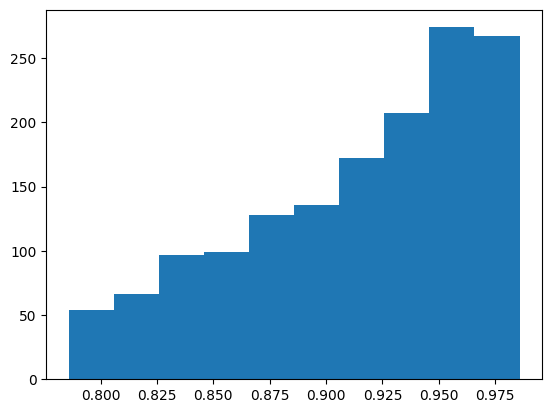

In [9]:
import matplotlib.pyplot as plt

plt.hist(df_y.iloc[:,1])
plt.show()

In [10]:
from autoemulate.core.compare import AutoEmulate
from autoemulate.emulators.gaussian_process.kernel import rbf, rbf_plus_constant
from autoemulate.emulators.transformed.base import TransformedEmulator
from autoemulate.transforms import StandardizeTransform, PCATransform

em = TransformedEmulator(
    x_train,
    y_train,
    model=GaussianProcess,
    x_transforms=[StandardizeTransform()],
    y_transforms=[StandardizeTransform()],
    covar_module_fn=rbf_plus_constant,
)

em.fit(x_train, y_train)


In [11]:
from torchmetrics import R2Score
from autoemulate.core.model_selection import evaluate

evaluate(em.predict(x_train), y_train, metric=R2Score)

/Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


0.9981386661529541

In [12]:
evaluate(em.predict(x_test), y_test, metric=R2Score)


0.9992839097976685

In [13]:
from autoemulate.core.compare import AutoEmulate

ae = AutoEmulate(x, y, models=[GaussianProcess], log_level="debug", model_tuning=False)


INFO    2025-08-01 12:13:36,999 - autoemulate - Comparing ['GaussianProcess']
INFO    2025-08-01 12:13:37,016 - autoemulate - Running Model: GaussianProcess: 1/1 (attempt 1/3)
DEBUG   2025-08-01 12:13:37,017 - autoemulate - Skipping tuning for model "GaussianProcess", using defaultparameters
DEBUG   2025-08-01 12:13:37,017 - autoemulate - Running cross-validation for model "GaussianProcess" for "10" iterations
DEBUG   2025-08-01 12:13:40,435 - autoemulate - Cross-validation for model "GaussianProcess" completed with test mean (std) R2 score: 0.998 (0.000), mean (std) RMSE score: 0.045 (0.003)
INFO    2025-08-01 12:13:40,436 - autoemulate - Finished running Model: GaussianProcess

DEBUG   2025-08-01 12:13:40,436 - autoemulate - ('Comparison results:\nBest Model: GaussianProcess, x transforms: [StandardizeTransform()], y transforms: [StandardizeTransform()]', 'Best params: {}, R2 score: 0.998, RMSE score: 0.045')


In [14]:
# plt.scatter(df_x.iloc[:, 0], df_y.iloc[:, 1])

WARNING 2025-08-01 12:13:40,456 - py.warnings - /Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(



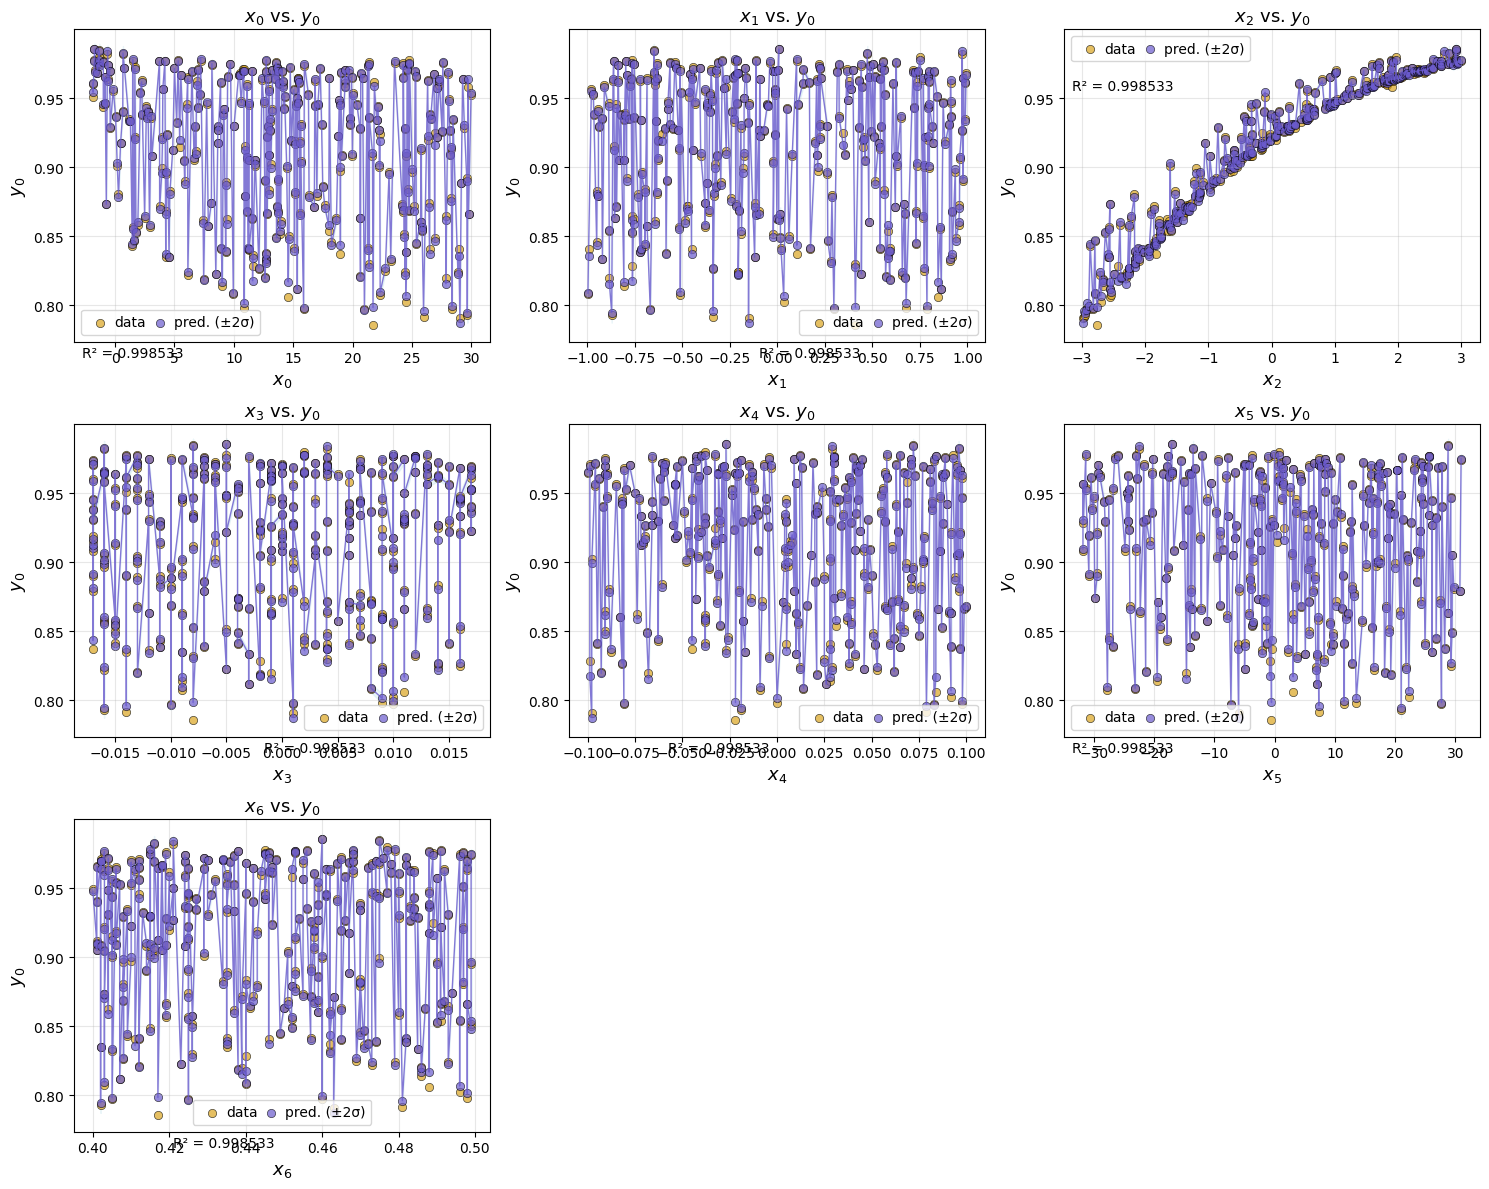

In [15]:

ae.plot(0)


In [16]:
df_x

,target_snr_db,phase_offset,iq_amplitude_imbalance_db,iq_phase_imbalance,iq_dc_offset_db,shift,coherence_bandwidth
0,0.927,0.275,-2.988,-0.004,0.002,-2.467,0.475
1,2.099,-0.322,-1.502,-0.003,-0.096,0.992,0.402
2,23.238,0.786,-0.999,-0.004,0.100,14.818,0.408
3,6.747,-0.535,-0.818,-0.016,0.068,-17.768,0.491
4,14.491,-0.492,-0.646,0.006,0.094,-4.804,0.476
...,...,...,...,...,...,...,...
1495,11.448,-0.681,0.025,0.011,-0.100,12.712,0.411
1496,4.382,-0.570,-0.575,-0.012,-0.034,-22.387,0.480
1497,1.143,0.857,2.578,0.000,-0.098,-2.303,0.409
1498,10.871,0.171,2.619,-0.017,0.036,-30.991,0.400


In [17]:
from autoemulate.simulations.base import Simulator

class ModError(Simulator):
    def __init__(
        self,
        parameters_range: dict[str, tuple[float, float]],
        output_names: list[str],
        log_level: str = "progress_bar",
    ):  
        super().__init__(parameters_range, output_names, log_level=log_level)
    
    def _forward(self, x):
        # Add function to go from parameters to output (SER)
        pass

In [18]:
sim = ModError(parameters_range={
    "target_snr_db": (-2.0, 30.0),
    "phase_offset": (-1.0, 1.0),
    "iq_amplitude_imbalance_db": (-3.0, 3.0)
}, output_names=["SER"])

In [19]:

df_x.columns

Index(['target_snr_db', 'phase_offset', 'iq_amplitude_imbalance_db',
       'iq_phase_imbalance', 'iq_dc_offset_db', 'shift',
       'coherence_bandwidth'],
      dtype='object')

In [20]:
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis

problem = {
    "num_vars": len(df_x.columns),
    "names": df_x.columns.tolist(),
    "bounds": [
        (df_x[col].min(), df_x[col].max()) for col in df_x.columns
    ],
}

sa = SensitivityAnalysis(emulator=ae.best_result().model, problem=problem)

df_sa = sa.run()

WARNING 2025-08-01 12:13:42,520 - py.warnings - /Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))



In [21]:
# autoemulate-error-quantification

In [22]:

df_sa

,output,parameter,index,value,confidence
0,y1,target_snr_db,S1,0.050071,0.006958
1,y1,phase_offset,S1,0.000082,0.000019
2,y1,iq_amplitude_imbalance_db,S1,0.959307,0.057313
3,y1,iq_phase_imbalance,S1,0.000057,0.000010
4,y1,iq_dc_offset_db,S1,0.000383,0.000056
5,y1,shift,S1,0.000065,0.000008
6,y1,coherence_bandwidth,S1,0.000057,0.000008
0,y1,target_snr_db,ST,0.036098,0.017996
1,y1,phase_offset,ST,0.000024,0.000717
2,y1,iq_amplitude_imbalance_db,ST,0.945782,0.066160


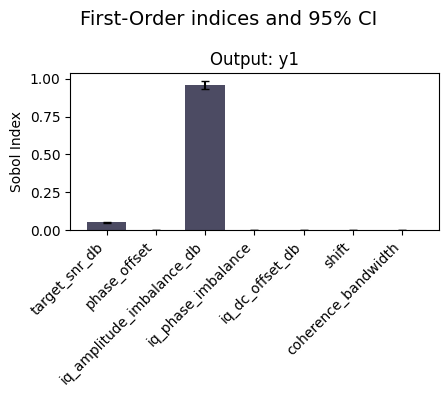

In [23]:
sa.plot_sobol(df_sa)

## 1. Simple HMC example.

In [24]:
from autoemulate.calibration.bayes import BayesianCalibration

Start with an "observation" that the GP has been trained on. 

Specifically, we will pretend we have N noisy experimental measurements. We should be able to recover the input parameters.

In [25]:
idx = -1 # which simulated value to pick
n_obs = 100
noise_scale = 0.05 # set noise as some ratio of the observed value

# observations = {"SER": torch.Tensor([0.6]*100)}
observations = {"SER": torch.Tensor([1.0]*100)}
observations

{'SER': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [26]:
df_x

,target_snr_db,phase_offset,iq_amplitude_imbalance_db,iq_phase_imbalance,iq_dc_offset_db,shift,coherence_bandwidth
0,0.927,0.275,-2.988,-0.004,0.002,-2.467,0.475
1,2.099,-0.322,-1.502,-0.003,-0.096,0.992,0.402
2,23.238,0.786,-0.999,-0.004,0.100,14.818,0.408
3,6.747,-0.535,-0.818,-0.016,0.068,-17.768,0.491
4,14.491,-0.492,-0.646,0.006,0.094,-4.804,0.476
...,...,...,...,...,...,...,...
1495,11.448,-0.681,0.025,0.011,-0.100,12.712,0.411
1496,4.382,-0.570,-0.575,-0.012,-0.034,-22.387,0.480
1497,1.143,0.857,2.578,0.000,-0.098,-2.303,0.409
1498,10.871,0.171,2.619,-0.017,0.036,-30.991,0.400


In [27]:

parameters_range = dict(zip(problem["names"], problem["bounds"]))
# use the simulator parameter_range 
bc = BayesianCalibration(em, parameters_range, observations, 10.0)

Run MCMC (note that below we have set the number of MCMC steps to a very low number, don't expect convergence).

In [28]:
mcmc = bc.run_mcmc(
    warmup_steps=100, 
    num_samples=1000,
    sampler='nuts',
)

Sample: 100%|██████████| 1100/1100 [00:20, 52.96it/s, step size=4.05e-01, acc. prob=0.956]


The returned Pyro MCMC object has methods for accessing the generated samples (`mcmc.get_samples()`) or, as shown below, to get their summary statistics.

In [29]:
mcmc.summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        coherence_bandwidth      0.45      0.03      0.45      0.40      0.49   1376.01      1.00
  iq_amplitude_imbalance_db      0.00      1.72     -0.06     -2.37      2.95   1513.35      1.00
            iq_dc_offset_db     -0.00      0.06     -0.01     -0.10      0.08   1415.68      1.00
         iq_phase_imbalance     -0.00      0.01      0.00     -0.02      0.01   1022.73      1.00
               phase_offset      0.03      0.57      0.05     -0.79      0.97    667.88      1.00
                      shift     -0.36     18.03     -0.09    -25.15     30.79   2361.23      1.00
              target_snr_db     13.95      9.06     13.88      1.55     29.96   1090.82      1.00

Number of divergences: 0


## 2. Plotting with Arviz

We have an option to turn the MCMC object into an Arviz object, which can be passed to any of their plotting function.

In [30]:
import arviz as az

In [31]:
az_data = bc.to_arviz(mcmc, posterior_predictive=True)

WARNING 2025-08-01 12:14:07,901 - py.warnings - /Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:653.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)

WARNING 2025-08-01 12:14:07,990 - py.warnings - /Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



array([[<Axes: title={'center': 'coherence_bandwidth'}>,
        <Axes: title={'center': 'coherence_bandwidth'}>],
       [<Axes: title={'center': 'iq_amplitude_imbalance_db'}>,
        <Axes: title={'center': 'iq_amplitude_imbalance_db'}>],
       [<Axes: title={'center': 'iq_dc_offset_db'}>,
        <Axes: title={'center': 'iq_dc_offset_db'}>],
       [<Axes: title={'center': 'iq_phase_imbalance'}>,
        <Axes: title={'center': 'iq_phase_imbalance'}>],
       [<Axes: title={'center': 'phase_offset'}>,
        <Axes: title={'center': 'phase_offset'}>],
       [<Axes: title={'center': 'shift'}>,
        <Axes: title={'center': 'shift'}>],
       [<Axes: title={'center': 'target_snr_db'}>,
        <Axes: title={'center': 'target_snr_db'}>]], dtype=object)

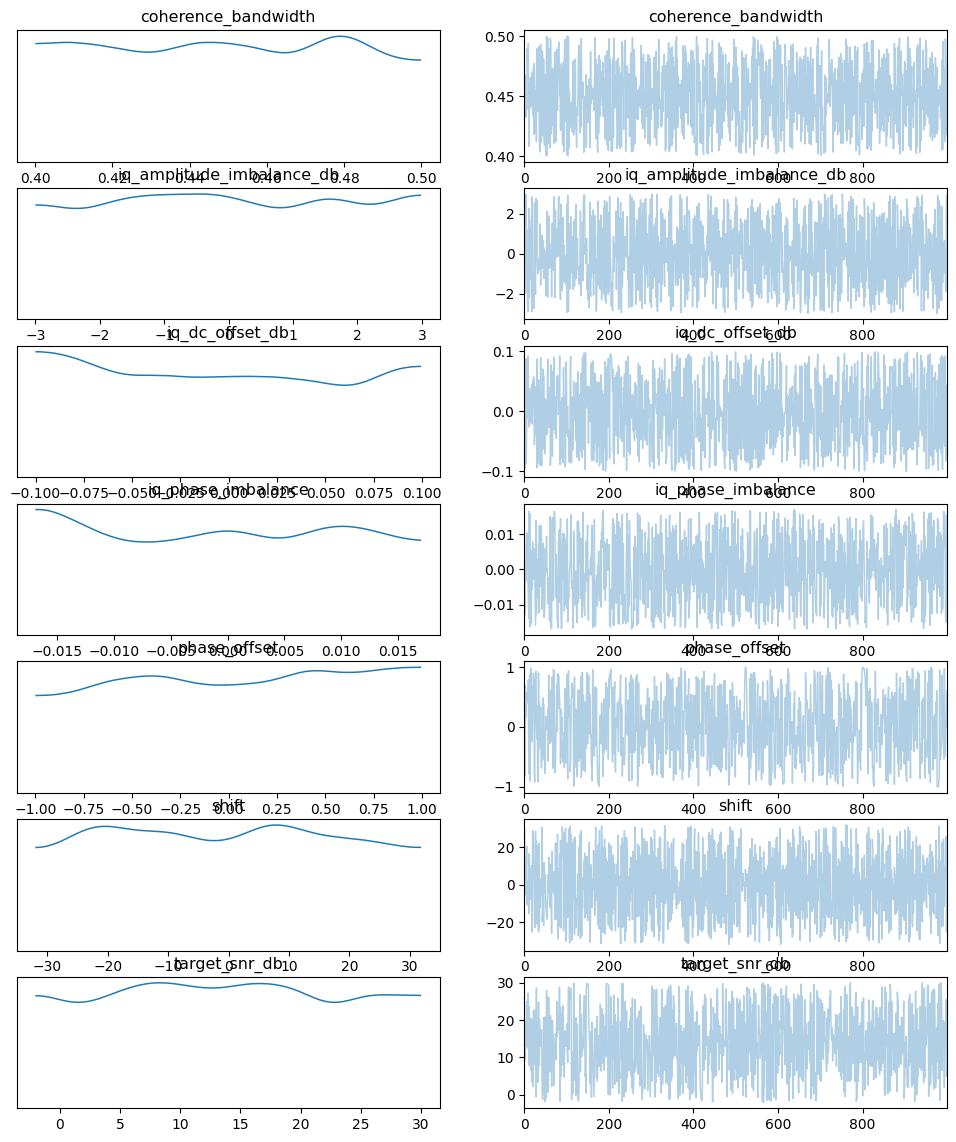

In [32]:
az.plot_trace(az_data)

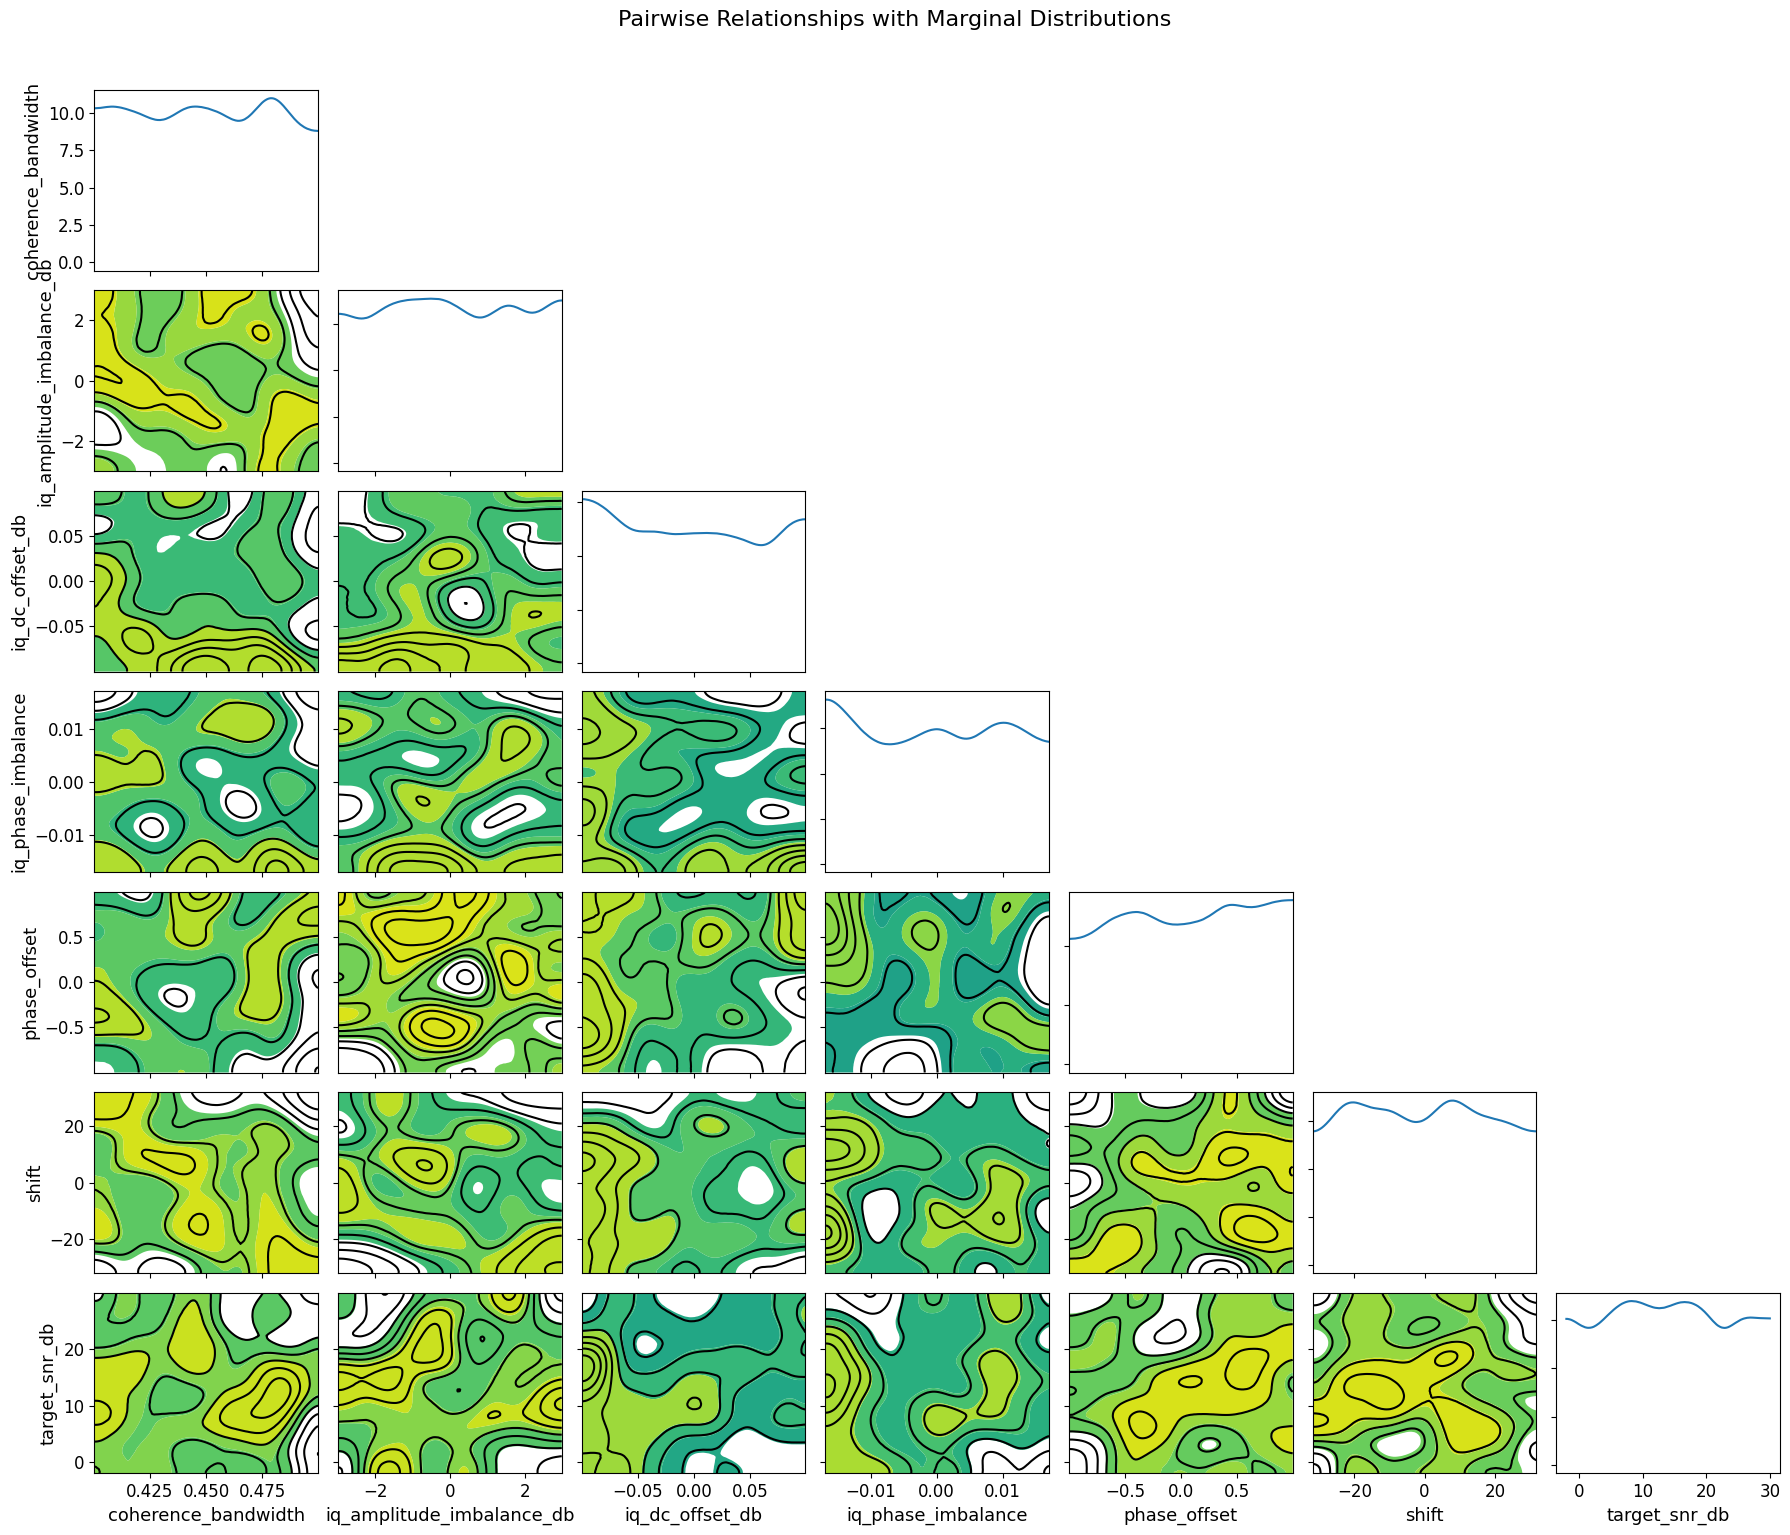

In [43]:
import arviz as az
import matplotlib.pyplot as plt

# Create the plot with explicit settings
az.plot_pair(
    az_data,
    kind='kde',
    marginals=True,
    figsize=(18, 15),
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Custom contour levels
        'contourf_kwargs': {'alpha': 0.7},
        'contour_kwargs': {'colors': 'k'}
    },
    backend='matplotlib',
    textsize=12  # Larger labels for better readability
)

# Add super title
plt.suptitle("Pairwise Relationships with Marginal Distributions", y=1.02, size=16)

plt.tight_layout()
plt.show()

<Axes: xlabel='SER'>

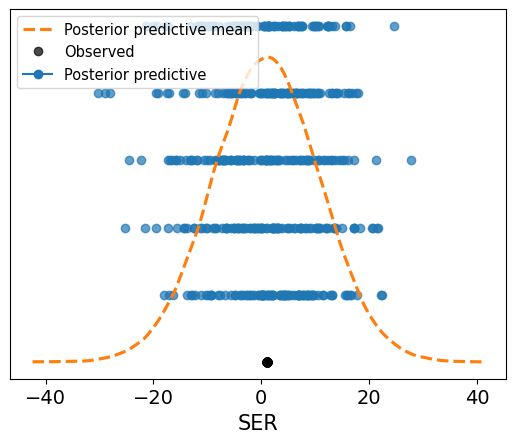

In [34]:
az.plot_ppc(az_data, kind='scatter')

array([[<Axes: title={'center': 'coherence_bandwidth\n0'}>,
        <Axes: title={'center': 'iq_amplitude_imbalance_db\n0'}>,
        <Axes: title={'center': 'iq_dc_offset_db\n0'}>],
       [<Axes: title={'center': 'iq_phase_imbalance\n0'}>,
        <Axes: title={'center': 'phase_offset\n0'}>,
        <Axes: title={'center': 'shift\n0'}>],
       [<Axes: title={'center': 'target_snr_db\n0'}>, <Axes: >, <Axes: >]],
      dtype=object)

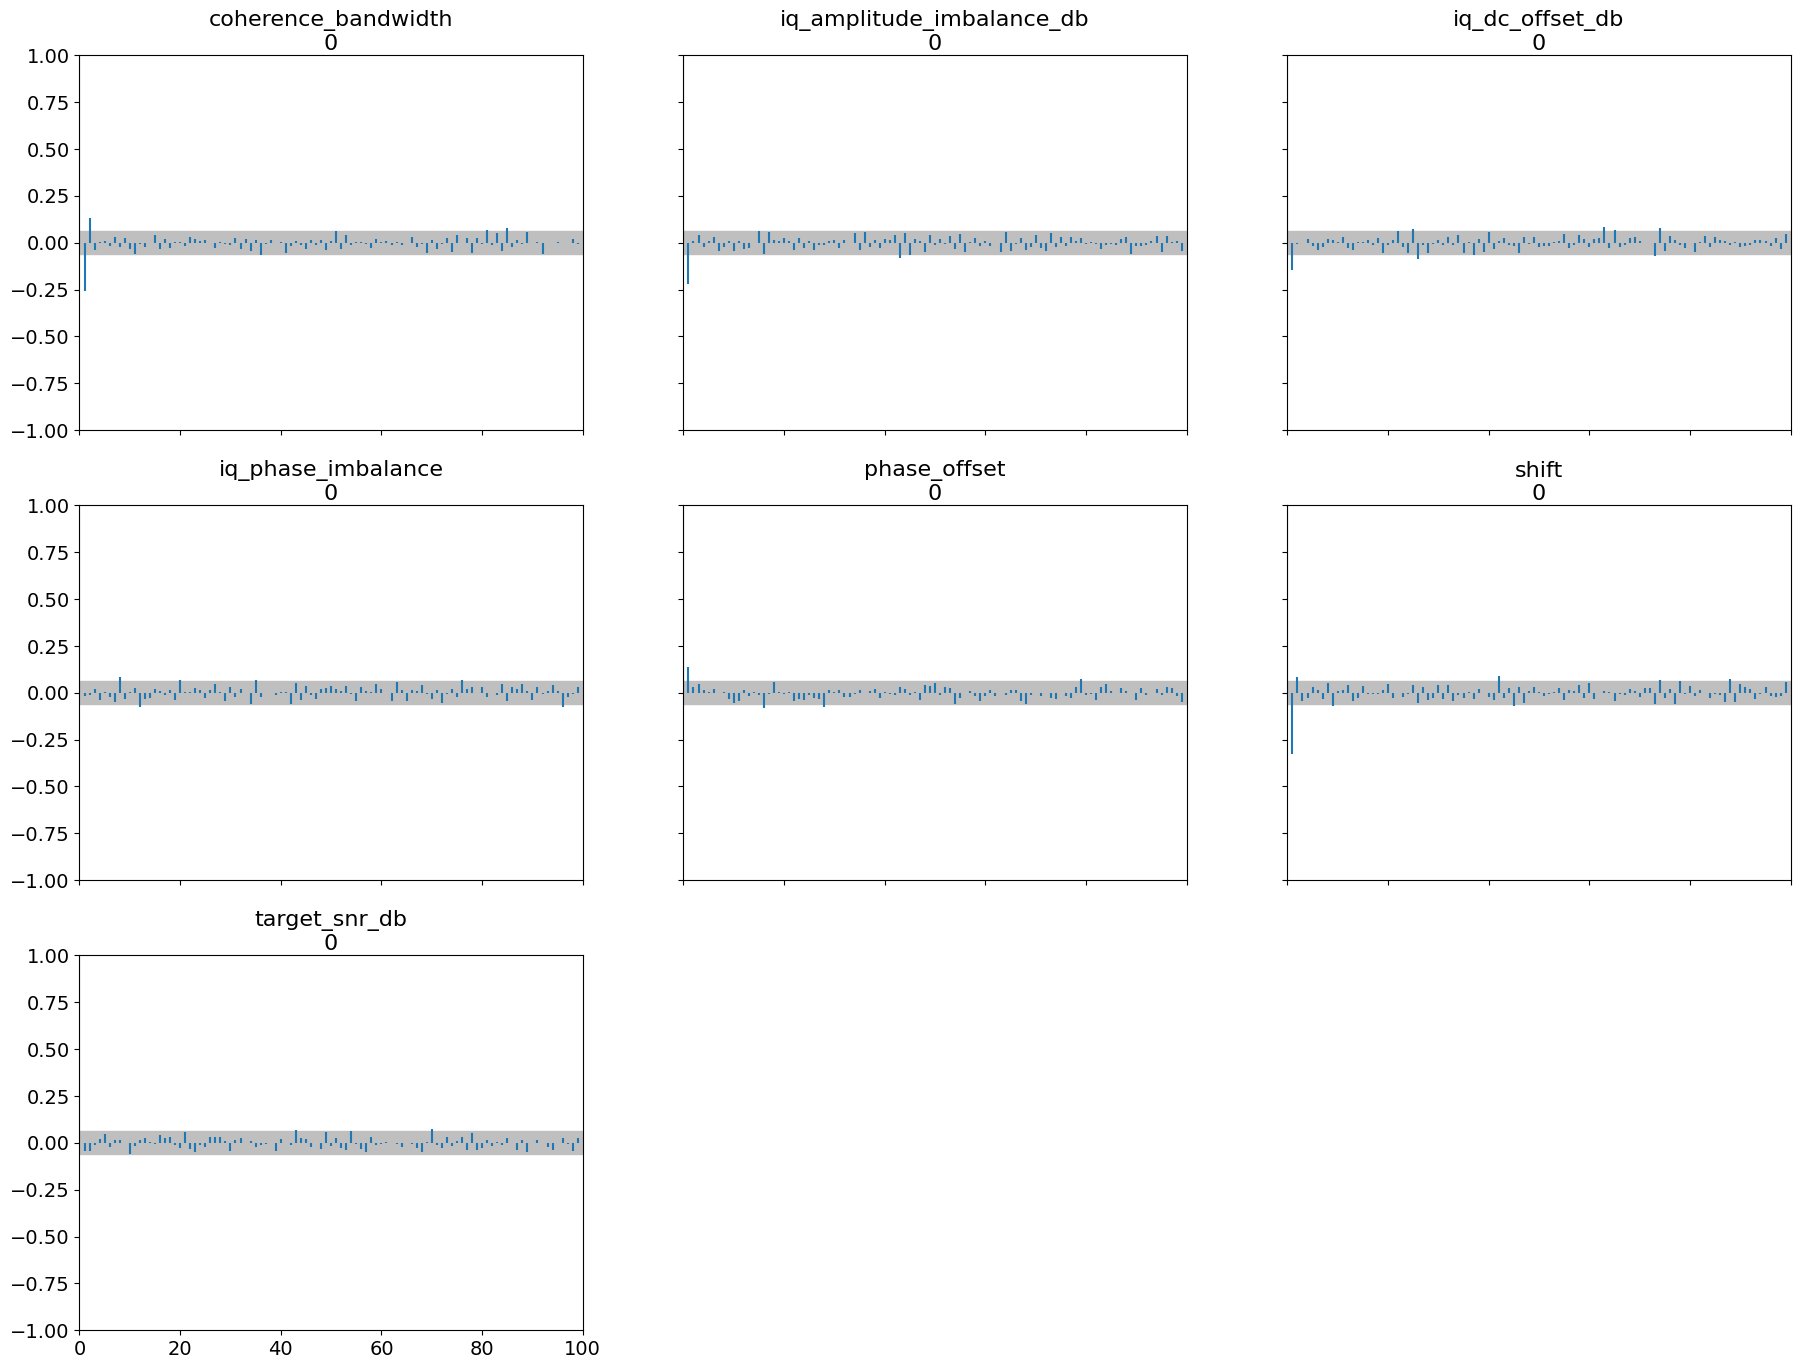

In [35]:
az.plot_autocorr(az_data)